# Graphene Hall Bar

## Importing statements

In [1]:
import kwant
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as la

## Building the sysytem

In [2]:
W = 20
L = 60
offset = 5

t = 1

def central_shape(site):
    # x, y = site.pos
    x, y = site
    return 0 < y < W and 0 < x < L

def lead01_shape(site):
    # x, y = site.pos
    x, y = site
    return 0 < y < W

def lead23_shape(site):
    # x, y = site.pos
    x, y = site
    return offset < x < offset + W/2

def lead45_shape(site):
    # x, y = site.pos
    x, y = site
    return (L-offset) - W/2 < x < L-offset

In [3]:
def hopping(a, b, t, peierls):
    return -t * peierls(a, b)

In [4]:
lat = kwant.lattice.honeycomb(a=1, norbs=1)
syst = kwant.Builder()

syst[lat.shape(central_shape,(L/2, W/2))] = 0
syst[lat.neighbors()] = hopping

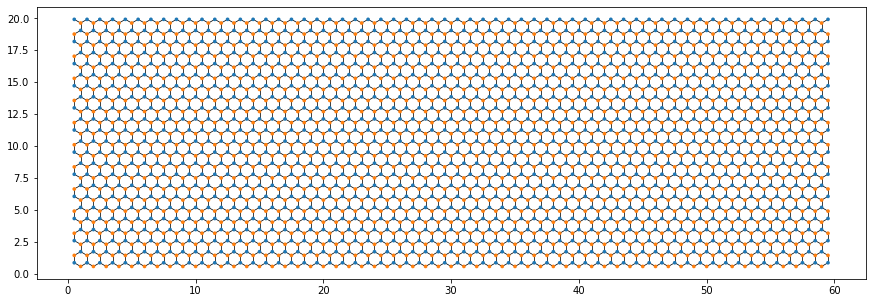

In [5]:
fig, ax = plt.subplots(figsize=(15,5))
ax.set_aspect('equal')
kwant.plot(syst, ax=ax)

In [6]:
## Leads 0 and 1:
symmetry_0 = kwant.TranslationalSymmetry((-1,0))
symmetry_0.add_site_family(lat.sublattices[0], other_vectors=[(-1,2)])
symmetry_0.add_site_family(lat.sublattices[1], other_vectors=[(-1,2)])

lead0 = kwant.Builder(symmetry=symmetry_0)
lead0[lat.shape(lead01_shape, (-1,0))] = 0
lead0[lat.neighbors()] = hopping

lead1 = lead0.reversed()

In [7]:
lead0 = lead0.substituted(peierls='peierls_lead_0')
lead1 = lead1.substituted(peierls='peierls_lead_1')

In [8]:
for lead in [lead0, lead1]:
    syst.attach_lead(lead)

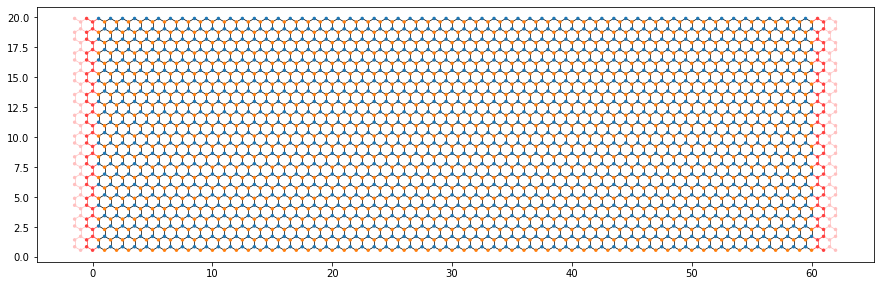

In [9]:
fig, ax = plt.subplots(figsize=(15,5))
ax.set_aspect('equal')
kwant.plot(syst, ax=ax)

In [10]:
## Leads 2 and 3:
symmetry_2 = kwant.TranslationalSymmetry((0,-np.sqrt(3)))

lead2 = kwant.Builder(symmetry=symmetry_2)
lead2[lat.shape(lead23_shape, (offset+W/4,-1))] = 0
lead2[lat.neighbors()] = hopping

lead3 = lead2.reversed()

In [11]:
lead2 = lead2.substituted(peierls='peierls_lead_2')
lead3 = lead3.substituted(peierls='peierls_lead_3')

In [12]:
for lead in [lead2, lead3]:
    syst.attach_lead(lead)

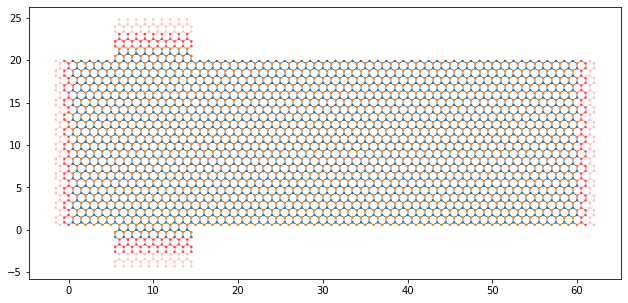

In [13]:
fig, ax = plt.subplots(figsize=(15,5))
ax.set_aspect('equal')
kwant.plot(syst, ax=ax)

In [14]:
## Leads 4 and 5:
lead4 = kwant.Builder(symmetry=symmetry_2)
lead4[lat.shape(lead45_shape, (L-(offset+W/2),-1))] = 0
lead4[lat.neighbors()] = hopping

lead5 = lead4.reversed()

In [15]:
lead4 = lead4.substituted(peierls='peierls_lead_4')
lead5 = lead5.substituted(peierls='peierls_lead_5')

In [16]:
for lead in [lead4, lead5]:
    syst.attach_lead(lead)

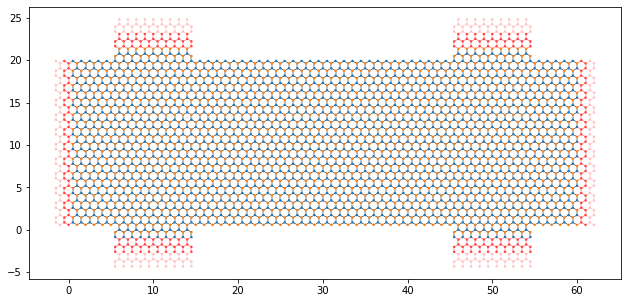

In [17]:
fig, ax = plt.subplots(figsize=(15,5))
ax.set_aspect('equal')
kwant.plot(syst, ax=ax)

In [18]:
Bsyst = 0.1
Blist = [Bsyst] + 6 * [0]

print(Blist)

gauge = kwant.physics.magnetic_gauge(syst.finalized())
peierls_syst, peierls0, peierls1, peierls2, peierls3, peierls4, peierls5 = gauge(*Blist)

[0.1, 0, 0, 0, 0, 0, 0]


In [19]:
params_dict = dict(t=1, 
             peierls   = peierls_syst,
             peierls_lead_0 = peierls0,
             peierls_lead_1 = peierls1,
             peierls_lead_2 = peierls2,
             peierls_lead_3 = peierls3,
             peierls_lead_4 = peierls4,
             peierls_lead_5 = peierls5,)

## Band structure

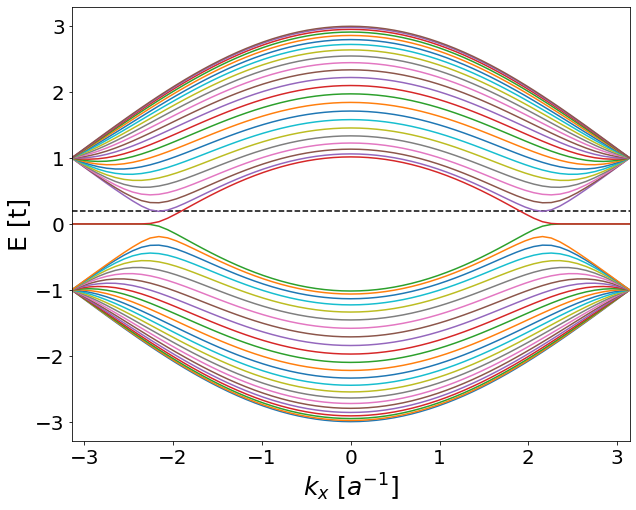

In [20]:
fig, ax = plt.subplots(figsize=(10,8))
# ax.set_ylim(-1,1)
ax.set_xlim(-np.pi, np.pi)
ax.axhline(y=0.2, ls='--', c='k')
ax.tick_params(labelsize=20)
ax.set_ylabel("E [t]", fontsize=25)
ax.set_xlabel(r"$k_x$ [$a^{-1}$]", fontsize=25)
kwant.plotter.bands(syst.leads[0].finalized(), ax=ax, params=params_dict);

## Wavefunction

In [21]:
wf = kwant.wave_function(syst.finalized(), energy=0.2, 
                         params=params_dict)

In [22]:
psi = wf(0)[0]

In [23]:
density = np.abs(psi)**2
print(density.max())

0.07430189540915266


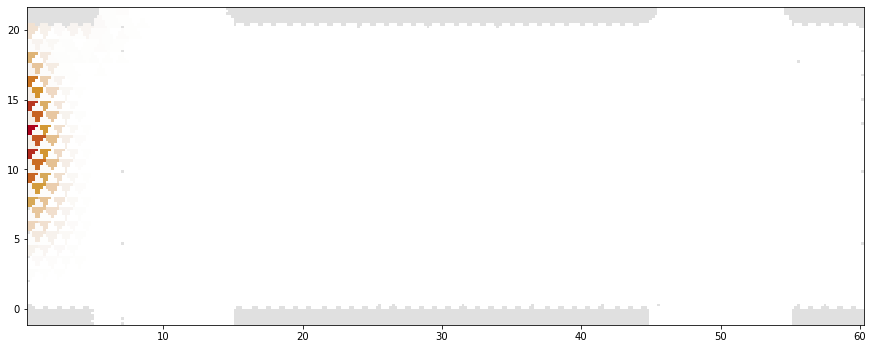

In [24]:
fig, ax = plt.subplots(figsize=(15,7))
kwant.plotter.map(syst.finalized(), density, vmax=np.max(density), ax=ax);

In [25]:
J_0 = kwant.operator.Current(syst.finalized())

In [26]:
current = J_0(psi, params=params_dict)

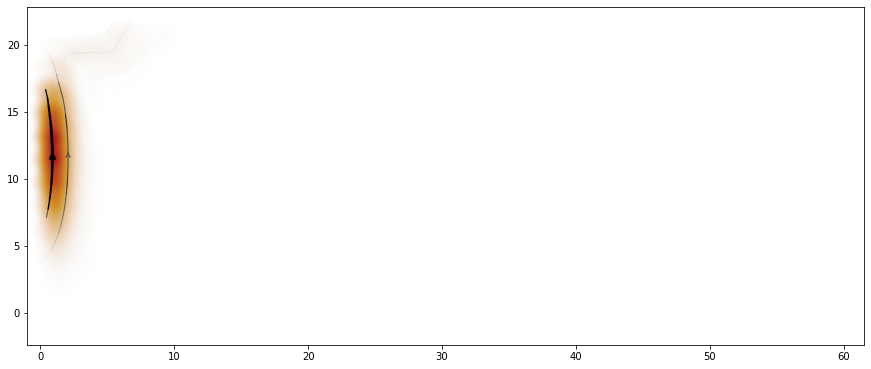

In [27]:
fig, ax = plt.subplots(figsize=(15,7))
kwant.plotter.current(syst.finalized(), current, ax=ax);

## Conductance

In [ ]:
def conductivities_array(Bvalues, mu_lead):
    E = 0.2
    sxx_array = []
    sxy_array = []
    
    for B in Bvalues:
        Blist = [B]+6*[0]
        gauge = kwant.physics.magnetic_gauge(syst.finalized())
        peierls_syst, peierls0, peierls1, peierls2, peierls3, peierls4, peierls5 = gauge(*Blist)
        params_dict = dict(t=1, peierls   = peierls_syst,
                            peierls_lead_0 = peierls0,
                            peierls_lead_1 = peierls1,
                            peierls_lead_2 = peierls2,
                            peierls_lead_3 = peierls3,
                            peierls_lead_4 = peierls4,
                            peierls_lead_5 = peierls5,)
        
        smat = kwant.smatrix(syst.finalized(), energy=mu_lead, params=params_dict)
        G = smat.conductance_matrix()
        sxx, sxy = conductivities(G)
        sxx_array.append(sxx)
        sxy_array.append(sxy)
        
    return np.array(sxx_array), np.array(sxy_array)
    


def conductivities(G):
#     G = kwant.smatrix(syst, energy=mu, params=p).conductance_matrix()
    # Voltages are given by G V = I
    V = np.linalg.solve(G[1:,1:], [1, 0, 0, 0, 0])
    # Consider the 2x2 conductance now: Use I = sigma U
    E_x = V[4] - V[2]
    E_y = V[2] - V[1]
    sigma_xx = E_x / (E_x ** 2 + E_y ** 2)
    sigma_xy = E_y / (E_x ** 2 + E_y ** 2)
    return sigma_xx, sigma_xy

In [91]:
G_collection = []
V_collection = []
T_collection = []

Bvalues = np.linspace(0.01, .2, 100)
E = 0.2

for B in Bvalues:
    Blist = [B]+6*[0]
    gauge = kwant.physics.magnetic_gauge(syst.finalized())
    peierls_syst, peierls0, peierls1, peierls2, peierls3, peierls4, peierls5 = gauge(*Blist)
    params_dict = dict(t=1, peierls   = peierls_syst,
                        peierls_lead_0 = peierls0,
                        peierls_lead_1 = peierls1,
                        peierls_lead_2 = peierls2,
                        peierls_lead_3 = peierls3,
                        peierls_lead_4 = peierls4,
                        peierls_lead_5 = peierls5,)
    smat = kwant.smatrix(syst.finalized(), energy=E, params=params_dict)
    
    T_collection.append(smat.transmission(1, 0))
    
    G = smat.conductance_matrix()
    G_new = G[1:,1:]
    G_collection.append(G_new)
    Ginv_new = la.inv(G_new)
    current = np.array([1, 0, 0, 0, 0])
    V = Ginv_new @ current
    V_collection.append(V)

KeyboardInterrupt: 

In [100]:
Bvalues_test = np.linspace(0.001, .01, 100)
sxx_test, sxy_test = conductivities_array(Bvalues_test, 0.2)

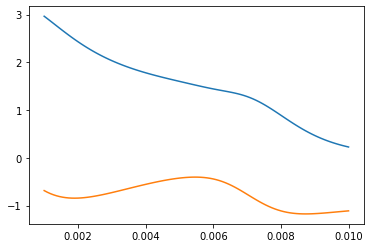

In [101]:
plt.plot(Bvalues_test, sxx_test)
plt.plot(Bvalues_test, sxy_test)
# plt.xlim(0,4)

In [67]:
# G_test = smat.conductance_matrix()
# G_test.shape

In [68]:
G_collection[0].shape

(5, 5)

In [74]:
Gxx0 = np.array([G[0,0] for G in G_collection])
Gxx1 = np.array([G[1,1] for G in G_collection])
Gxx2 = np.array([G[2,2] for G in G_collection])
Gxx3 = np.array([G[3,3] for G in G_collection])
Gxx4 = np.array([G[4,4] for G in G_collection])

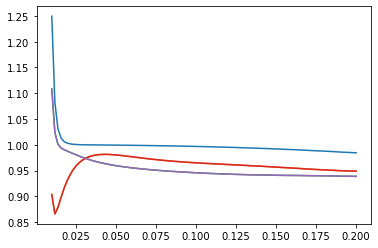

In [75]:
plt.plot(Bvalues, Gxx0);
plt.plot(Bvalues, Gxx1);
plt.plot(Bvalues, Gxx2);
plt.plot(Bvalues, Gxx3);
plt.plot(Bvalues, Gxx4);

In [29]:
V_collection_array = np.array(V_collection) 

In [30]:
Rxx = np.array([V[0] for V in V_collection])
Rxy = np.array([V[4]-V[2] for V in V_collection])

sigma_xx = 1/Rxx
sigma_xy = 1/Rxy

In [43]:
Ex_list = np.array([(V[4]-V[2]+V[3]-V[1])/(2*40) for V in V_collection])

In [44]:
Ey_list = np.array([(V[2]-V[1]+V[4]-V[3])/(2*20) for V in V_collection])

In [51]:
sigma_H = (1/20) * Ey_list/(Ex_list**2 + Ey_list**2)
sigma_L = sigma_H * Ex_list/Ey_list

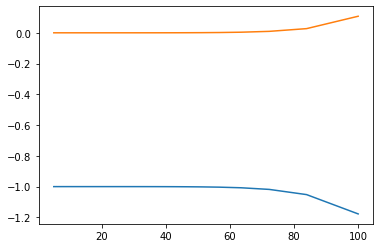

In [53]:
plt.plot(Bvalues, sigma_H)
plt.plot(Bvalues, sigma_L)

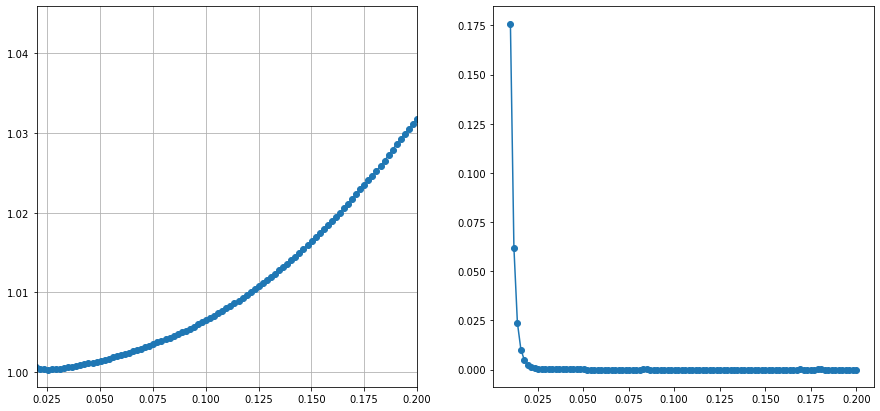

In [31]:
fig, ax = plt.subplots(ncols=2, figsize=(15,7))
ax[0].plot(Bvalues, Rxx, '-o')
# ax[0].plot(Bvalues, sigma_xx, '-o')
ax[0].grid()
ax[0].set_xlim(0.02, 0.2)
# ax[0].set_ylim(1.0002,1.0006)
ax[1].plot(Bvalues, Rxy, '-o')
# ax[1].set_xlim(0.02, 0.03)
# ax[1].set_ylim(0.00,0.00001)
# ax[1].set_ylabel(r'$\$')

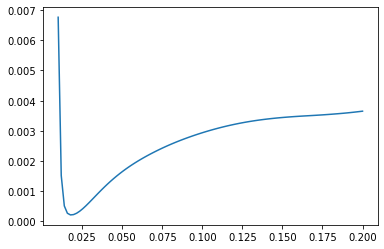

In [32]:
plt.plot(Bvalues, T_collection)

In [33]:
unit_cell_area = 3 * np.sqrt(3)/2 * (0.14)**2 ## nm^2
print("Area of graphene cell = {:2.2f} nm^2".format(unit_cell_area))

Area of graphene cell = 0.05 nm^2


In [34]:
Φ_0 = 2.067833848E-15 ## Wb
Φ_1T = unit_cell_area * 1e-18 ## Wb
Φ_ratio = Φ_1T/Φ_0

print('{:2.3g}'.format(Φ_ratio))

2.46e-05


$$
\Phi_0 = \frac{h}{e} \approx 2.067 \times 10^{-15} \text{ Wb}
$$

For a magnetic field of 1 Tesla we would get 

$$
\Phi_{1T} = 0.05 \times 10^{-18} \text{ Wb}
$$

as the magnetic flux through a graphene unit cell. 

In this way, 

$$
\frac{\Phi_{1T}}{\Phi_0} = 2.46 \times 10^{-5}
$$

## Square lattice Hall bar 

In [164]:
# MAKE SYSTEM
def onsite(site, t, mu):
    (x, y) = site.pos
    return 4 * t - mu

def lead_onsite(site, t, mu_lead):
    return 4*t - mu_lead

def hopping(site1, site2, t, B):
    x1, y1 = site1.pos
    x2, y2 = site2.pos
    return -t * np.exp(-0.5j * B * (x1-x2)*(y1+y2))

def make_lead_hop_y(x0):
    def hopping_Ay(site1, site2, t, B):
        y1 = site1.pos[1]
        y2 = site2.pos[1]
        return -t * np.exp(-1j * B * x0 * (y1-y2))
    return hopping_Ay

def lead_hop_vert(site1, site2, t):
        return -t

def qhe_hall_bar(L=50, W=10, w_lead=10, w_vert_lead=None):
    """
    """
    L = 2 * (L // 2)
    W = 2 * (W // 2)
    w_lead = 2 * (w_lead // 2)
    if w_vert_lead is None:
        w_vert_lead = w_lead
    else:
        w_vert_lead = 2 * (w_vert_lead // 2)

    # bar shape
    def bar(pos):
        (x, y) = pos
        return (x >= -L / 2 and x <= L / 2) and (y >= -W / 2 and y <= W / 2)

#     def hopping_Ax(site1, site2, t, B):
#         x1, y1 = site1.pos
#         x2, y2 = site2.pos
#         return -t * np.exp(-0.5j * B * (x1 + x2) * (y1 - y2))
#     # onsite and hoppings
    def hopping_Ax(site1, site2, t, B):
        x1, y1 = site1.pos
        x2, y2 = site2.pos
        return -t * np.exp(-0.5j * B * (x1+x2)*(y1-y2))
    
    # Building system
    lat = kwant.lattice.square()
    syst = kwant.Builder()
    syst[lat.shape(bar, (0,0))] = onsite
    syst[lat.neighbors()] = hopping_Ax
    
    # Attaching leads
    sym_lead = kwant.TranslationalSymmetry((-1,0))
    lead = kwant.Builder(sym_lead)
    
    def lead_shape(pos):
        (x, y) = pos
        return -w_lead/2 <= y <= w_lead/2
    
    sym_lead_vertical = kwant.TranslationalSymmetry((0,1))
    lead_vertical1 = kwant.Builder(sym_lead_vertical)
    lead_vertical2 = kwant.Builder(sym_lead_vertical)
    
    def lead_shape_vertical1(pos):
        x = pos[0]
        return -L/4 - w_vert_lead/2 <= x <= -L/4 + w_vert_lead/2
    
    def lead_shape_vertical2(pos):
        x = pos[0]
        return +L/4 - w_vert_lead/2 <= x <= +L/4 + w_vert_lead/2
    
#     fig, ax = plt.subplots()
#     ax.set_title("Scattering region")
#     kwant.plot(syst, ax=ax);
    
    lead_vertical1[lat.shape(lead_shape_vertical1, (-L/4, 0))] = lead_onsite
    lead_vertical1[lat.neighbors()] = lead_hop_vert
    lead_vertical2[lat.shape(lead_shape_vertical2, (L/4, 0))] = lead_onsite
    lead_vertical2[lat.neighbors()] = lead_hop_vert
    
#     fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(15,15))

    syst.attach_lead(lead_vertical1) ## Lead 0
#     ax[0,0].set_title("lead-0", fontsize=20)
#     kwant.plot(syst, show=False, ax=ax[0,0]);
    syst.attach_lead(lead_vertical2) ## Lead 1
#     ax[0,1].set_title("lead-1", fontsize=20)
#     kwant.plot(syst, show=False, ax=ax[0,1]);
    
    syst.attach_lead(lead_vertical1.reversed()) ## Lead 2
#     ax[1,0].set_title("lead-2", fontsize=20)
#     kwant.plot(syst, show=False, ax=ax[1,0]);
    syst.attach_lead(lead_vertical2.reversed()) ## Lead 3
#     ax[1,1].set_title("lead-3", fontsize=20)
#     kwant.plot(syst, show=False, ax=ax[1,1]);
    
    lead[lat.shape(lead_shape, (-1,0))] = lead_onsite
    lead[lat.neighbors()] = make_lead_hop_y(-L/2)
    
    syst.attach_lead(lead) ## Lead 4
#     ax[0,2].set_title("lead-4", fontsize=20)
#     kwant.plot(syst, show=False, ax=ax[0,2]);
    
    lead = kwant.Builder(sym_lead)
    lead[lat.shape(lead_shape, (-1,0))] = lead_onsite
    lead[lat.neighbors()] = make_lead_hop_y(L/2)
    
    syst.attach_lead(lead.reversed()) ## Lead 5
#     ax[1,2].set_title("lead-5", fontsize=20)
#     kwant.plot(syst, show=False, ax=ax[1,2]);
    return syst

In [165]:
syst = qhe_hall_bar(L=60, W=80, w_lead=70, w_vert_lead=28).finalized()

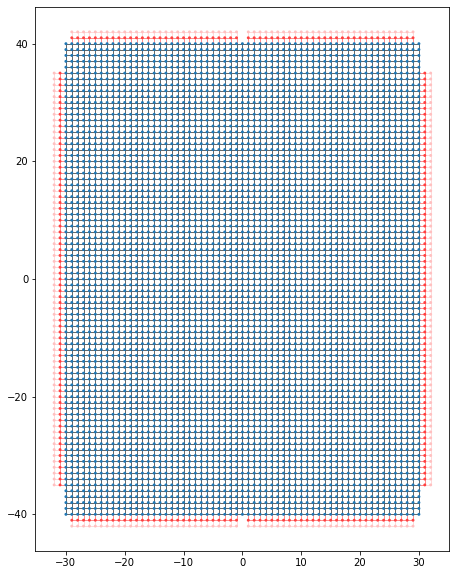

In [166]:
fig, ax = plt.subplots(figsize=(10,10))
ax.set_aspect('equal')
kwant.plot(syst, ax=ax)
plt.show()

In [167]:
p = dict(t=1.0, mu=0.3, mu_lead=0.3, B=None)
Bs = np.linspace(0.02, 0.15, 200)

In [168]:
def conductivities_topocondmat(syst, p):
    G = kwant.smatrix(syst, params=p).conductance_matrix()
    # Voltages are given by G V = I
    V = np.linalg.solve(G[:-1, :-1], [0, 0, 0, 0, 1])
    # Consider the 2x2 conductance now: Use I = sigma U
    E_x = V[0] - V[1]
    E_y = V[1] - V[3]
    sigma_xx = E_x / (E_x ** 2 + E_y ** 2)
    sigma_xy = E_y / (E_x ** 2 + E_y ** 2)
    return sigma_xx, sigma_xy

def calculate_sigmas(G):
    # reduce by one dimension G -> G[temp, temp]
    temp = [0, 1, 3, 4, 5]
    G = G[temp, :]
    G = G[:, temp]
    # invert R = G^-1
    # find out whether it is a numpy object
    r = np.linalg.inv(G)
    # Voltages follow: V = R I[temp]
    V = r @ np.array([0, 0, 0, 1, -1])
    # Completely solved the six terminal system.
    # Consider the 2x2 conductance now: Use I = sigma U
    E_x = V[1] - V[0]
    E_y = V[1] - V[3]
    # formula above
    sigma_xx = E_x / (E_x**2 + E_y**2)
    sigma_xy = E_y / (E_x**2 + E_y**2)
    return sigma_xx, sigma_xy

In [169]:
sigmasxx, sigmasxy = zip(*[conductivities_topocondmat(syst, p) for p["B"] in Bs])

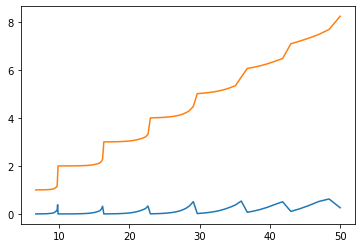

In [170]:
plt.plot(1/Bs, sigmasxx)
plt.plot(1/Bs, sigmasxy)

In [146]:
syst = qhe_hall_bar(L=60, W=100, w_lead=90, w_vert_lead=28).finalized()
p = dict(t=1.0, mu=0.3, mu_lead=0.3, B=None)

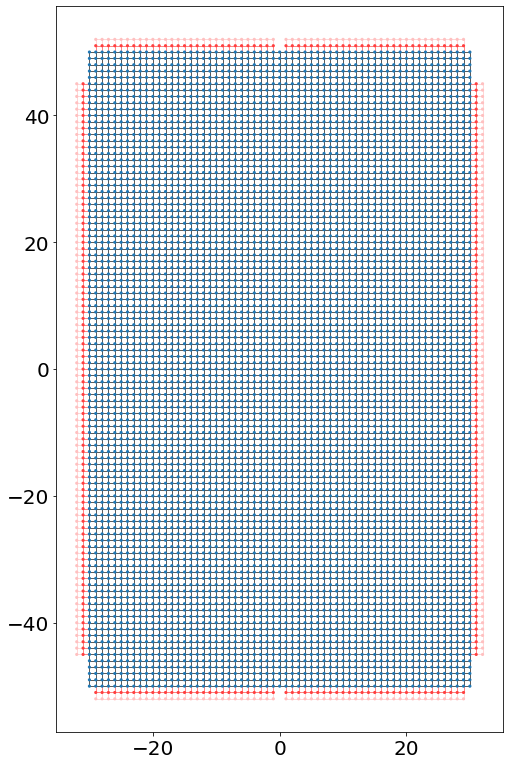

In [152]:
fig, ax = plt.subplots(figsize=(8,16))
ax.set_aspect('equal')
ax.tick_params(labelsize=20)
kwant.plot(syst, ax=ax);

In [153]:
Bs = np.linspace(0.02, 0.15, 200)
num_leads = len(syst.leads)

def G(syst, p):
    print(p['B'])
    smatrix = kwant.smatrix(syst, params=p)
    G = [[smatrix.transmission(i, j) for i in range(num_leads)] for j in range(num_leads)]
    G -= np.diag(np.sum(G, axis=0))
    return calculate_sigmas(G)

sigmasxx, sigmasxy = np.array([G(syst, p) for p['B'] in Bs]).T

0.02
0.02065326633165829
0.021306532663316582
0.021959798994974876
0.022613065326633167
0.023266331658291457
0.023919597989949748
0.02457286432160804
0.025226130653266333
0.025879396984924623
0.026532663316582914
0.02718592964824121
0.0278391959798995
0.02849246231155779
0.02914572864321608
0.02979899497487437
0.03045226130653266
0.031105527638190952
0.03175879396984925
0.032412060301507534
0.03306532663316583
0.03371859296482412
0.03437185929648241
0.0350251256281407
0.035678391959798994
0.036331658291457285
0.036984924623115575
0.03763819095477387
0.03829145728643216
0.038944723618090454
0.039597989949748745
0.040251256281407036
0.040904522613065326
0.04155778894472362
0.04221105527638191
0.0428643216080402
0.043517587939698496
0.04417085427135678
0.04482412060301508
0.04547738693467337
0.04613065326633166
0.04678391959798995
0.04743718592964824
0.04809045226130653
0.04874371859296482
0.04939698492462312
0.0500502512562814
0.0507035175879397
0.051356783919597984
0.05201005025125628
0

In [155]:
sigmasxx.shape

(200,)

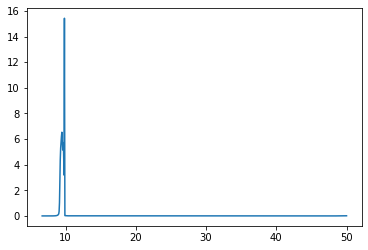

In [154]:
plt.plot(1/Bs, sigmasxx)

In [157]:
import types

class SimpleNamespace(types.SimpleNamespace):
    def update(self, **kwargs):
        self.__dict__.update(kwargs)
        return self

In [161]:
# Quantum hall bar codes
def qhe_hall_bar(L=50, W=10, w_lead=10, w_vert_lead=None):
    """Create a hall bar system. 

    Square lattice, one orbital per site.
    Returns kwant system.

    Arguments required in onsite/hoppings: 
        t, mu, mu_lead
    """

    L = 2 * (L // 2)
    W = 2 * (W // 2)
    w_lead = 2 * (w_lead // 2)
    if w_vert_lead is None:
        w_vert_lead = w_lead
    else:
        w_vert_lead = 2 * (w_vert_lead // 2)

    # bar shape
    def bar(pos):
        (x, y) = pos
        return (x >= -L / 2 and x <= L / 2) and (y >= -W / 2 and y <= W / 2)

    # Onsite and hoppings
#     def onsite(site, p):
#         (x, y) = site.pos
#         return 4 * p.t - p.mu
    
    def onsite(site, t, mu):
        (x, y) = site.pos
        return 4 * t - mu
    

#     def hopping_Ax(site1, site2, p):
#         x1, y1 = site1.pos
#         x2, y2 = site2.pos
#         return -p.t * np.exp(-0.5j * p.B * (x1 + x2) * (y1 - y2))

    def hopping_Ax(site1, site2, t, B):
        x1, y1 = site1.pos
        x2, y2 = site2.pos
        return -t * np.exp(-0.5j * B * (x1 + x2) * (y1 - y2))

#     def make_lead_hop_y(x0):
#         def hopping_Ay(site1, site2, p):
#             x1, y1 = site1.pos
#             x2, y2 = site2.pos
#             return -p.t * np.exp(-1j * p.B * x0 * (y1 - y2))
#         return hopping_Ay
    
    def make_lead_hop_y(x0):
        def hopping_Ay(site1, site2, t, B):
            x1, y1 = site1.pos
            x2, y2 = site2.pos
            return -t * np.exp(-1j * B * x0 * (y1 - y2))
        return hopping_Ay

#     def lead_hop_vert(site1, site2, p):
#         return -p.t
    
    def lead_hop_vert(site1, site2, t):
        return -t

    # Building system
    lat = kwant.lattice.square()
    syst = kwant.Builder()

    syst[lat.shape(bar, (0, 0))] = onsite
    syst[lat.neighbors()] = hopping_Ax

    # Attaching leads
    sym_lead = kwant.TranslationalSymmetry((-1, 0))
    lead = kwant.Builder(sym_lead)

    def lead_shape(pos):
        (x, y) = pos
        return (-w_lead / 2 <= y <= w_lead / 2)

#     lead_onsite = lambda site, p: 4 * p.t - p.mu_lead
    
    def lead_onsite(site, t, mu_lead):
        return 4 * t - mu_lead

    sym_lead_vertical = kwant.TranslationalSymmetry((0, 1))
    lead_vertical1 = kwant.Builder(sym_lead_vertical)
    lead_vertical2 = kwant.Builder(sym_lead_vertical)

    def lead_shape_vertical1(pos):
        (x, y) = pos
        return (-L / 4 - w_vert_lead / 2 <= x <= -L / 4 + w_vert_lead / 2)

    def lead_shape_vertical2(pos):
        (x, y) = pos
        return (+L / 4 - w_vert_lead / 2 <= x <= +L / 4 + w_vert_lead / 2)

    lead_vertical1[lat.shape(lead_shape_vertical1, (-L / 4, 0))] = lead_onsite
    lead_vertical1[lat.neighbors()] = lead_hop_vert
    lead_vertical2[lat.shape(lead_shape_vertical2, (L / 4, 0))] = lead_onsite
    lead_vertical2[lat.neighbors()] = lead_hop_vert

    syst.attach_lead(lead_vertical1)
    syst.attach_lead(lead_vertical2)

    syst.attach_lead(lead_vertical1.reversed())
    syst.attach_lead(lead_vertical2.reversed())

    lead[lat.shape(lead_shape, (-1, 0))] = lead_onsite
    lead[lat.neighbors()] = make_lead_hop_y(-L / 2)

    syst.attach_lead(lead)

    lead = kwant.Builder(sym_lead)
    lead[lat.shape(lead_shape, (-1, 0))] = lead_onsite
    lead[lat.neighbors()] = make_lead_hop_y(L / 2)

    syst.attach_lead(lead.reversed())

    return syst


def calculate_sigmas(G):
    # reduce by one dimension G -> G[temp, temp]
    temp = [0, 1, 3, 4, 5]
    G = G[temp, :]
    G = G[:, temp]
    # invert R = G^-1
    # find out whether it is a numpy object
    r = np.linalg.inv(G)
    # Voltages follow: V = R I[temp]
    V = r @ np.array([0, 0, 0, 1, -1])
    # Completely solved the six terminal system.
    # Consider the 2x2 conductance now: Use I = sigma U
    E_x = V[1] - V[0]
    E_y = V[1] - V[3]
    # formula above
    sigma_xx = E_x / (E_x**2 + E_y**2)
    sigma_xy = E_y / (E_x**2 + E_y**2)
    return sigma_xx, sigma_xy


In [163]:
syst = qhe_hall_bar(L=60, W=100, w_lead=90, w_vert_lead=28).finalized()
# p = SimpleNamespace(t=1.0, mu=0.3, mu_lead=0.3, B=None)
p = dict(t=1.0, mu=0.3, mu_lead=0.3, B=None)
Bs = np.linspace(0.02, 0.15, 200)
num_leads = len(syst.leads)
def G(syst, p):
    smatrix = kwant.smatrix(syst, params=p)
    G = [[smatrix.transmission(i, j) for i in range(num_leads)] for j in range(num_leads)]
    G -= np.diag(np.sum(G, axis=0))
    return calculate_sigmas(G)

sigmasxx, sigmasxy = np.array([G(syst, p) for p['B'] in Bs]).T

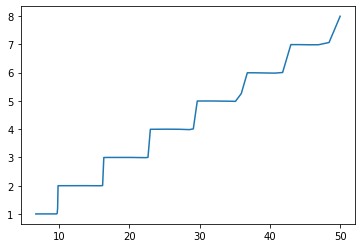

In [160]:
plt.plot(1/Bs, sigmasxy)